In [59]:
%matplotlib inline

In [60]:
from keras.applications import VGG16
#from keras.applications import InceptionResNetV2

In [61]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, BatchNormalization, Activation, Flatten, Dropout
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam, Nadam
import numpy as np
from PIL import Image
from scipy.misc import toimage
from matplotlib import pyplot as plt

In [62]:
base_model = VGG16(include_top=False, weights=None, input_tensor=None, input_shape=(3, 224, 224), pooling=None, classes=1000)

In [63]:
train_path = '/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/data/train/'
valid_path = '/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/data/valid/'
test_path = '/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/data/test/'
model_path = '/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/'

In [64]:
#base_model.summary()

In [65]:
#base_model.layers.pop()  # remove last max pooling layer
x = Flatten()(base_model.layers[-1].output)
x = BatchNormalization()(x)

x = Dense(4096, use_bias=False, kernel_initializer='uniform', activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(4096, use_bias=False, kernel_initializer='uniform', activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

y = Dense(10, kernel_initializer='uniform', name='state_farm_classifier', activation='softmax')(x)

inp = base_model.input
out = y

state_farm_model = Model(inp, out)

for i, layer in enumerate(state_farm_model.layers):
    if i < 19:
        state_farm_model.layers[i].trainable = False
    else:
        state_farm_model.layers[i].trainable = True

In [66]:
state_farm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

In [67]:
for layer in state_farm_model.layers:
    print(layer.name + " " + str(layer.trainable))

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_3 True
batch_normalization_7 True
dense_5 True
dropout_5 True
batch_normalization_8 True
dense_6 True
dropout_6 True
batch_normalization_9 True
state_farm_classifier True


In [68]:
state_farm_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
train_gen = image.ImageDataGenerator() #rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
valid_gen = image.ImageDataGenerator()
train_batches = train_gen.flow_from_directory(train_path, target_size=(224,224), shuffle=True, batch_size=8, class_mode='categorical')
valid_batches = valid_gen.flow_from_directory(valid_path, target_size=(224,224), shuffle=False, batch_size=8, class_mode='categorical')

Found 18047 images belonging to 10 classes.
Found 4377 images belonging to 10 classes.


In [74]:
state_farm_model.fit_generator(train_batches, steps_per_epoch=int(np.ceil(train_batches.samples/32)), epochs=1, 
                    validation_data = valid_batches, validation_steps=int(np.ceil(valid_batches.samples/32)) )

Epoch 1/1
564/564 [==============================] - 151s - loss: 11.8907 - acc: 0.2238 - val_loss: 10.1594 - val_acc: 0.3695


In [73]:
state_farm_model.optimizer.lr.set_value(0.01)
print(state_farm_model.optimizer.lr.get_value())

0.009999999776482582


In [20]:
state_farm_model.save_weights(model_path + 'state_farm.h5')

In [10]:
test_gen = image.ImageDataGenerator()
test_batches = test_gen.flow_from_directory(test_path, target_size=(224,224), shuffle=False, batch_size=8, class_mode=None)

Found 79726 images belonging to 1 classes.
/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/data/test/


In [22]:
steps = int(np.ceil(test_batches.samples/8))

In [23]:
pred_gen = state_farm_model.predict_generator(test_batches, steps)

In [24]:
pred_gen.shape

(79726, 10)

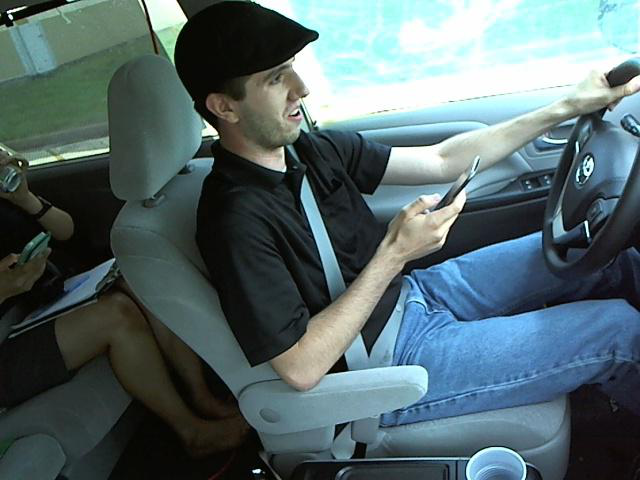

In [13]:
Image.open(test_path + test_batches.filenames[5])
#print(test_batches.filenames[0])

In [54]:
#probabilities = pred_gen.clip(min=0.05, max=0.95)

In [25]:
ids = [element[8:] for element in test_batches.filenames]
ids = np.asarray(ids).reshape(-1,1)
print(pred_gen.shape)
print(ids.shape)

(79726, 10)
(79726, 1)


In [26]:
results = np.concatenate([ids,pred_gen], axis=-1)
results.shape

(79726, 11)

In [27]:
submission_file_name = '/home/arman/deep-learning/kaggle-competitions/kaggle-state-farm-notebook/submission1.csv'

In [71]:
#with open(submission_file_name,'wb') as f:
#    np.savetxt(f, results, fmt='%s, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f', 
#    header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

In [28]:
np.savetxt(submission_file_name, results, fmt='%5s',delimiter=',', header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')